# Import modules (google colab syntax !)

In [388]:
!pip install lifelines
!pip install sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from google.colab import drive
# Mount Google Drive

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# unlabeled data

In [389]:
drive.mount('/content/drive')
# train data with DssTime
baseline_data_path = '/content/drive/MyDrive/train_data.csv'
# test data
test_data_path = '/content/drive/MyDrive/test_data.csv'
# train data labeled + unlabeled
#train_data_path = '/content/drive/MyDrive/combined_labeled_data_w_confidence.csv'
train_data_path = '/content/drive/MyDrive/pseudo_labelled_data_vime.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
baseline_data = pd.read_csv(baseline_data_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [390]:

# Preprocessing
#X_train_Cindex = train_data.drop(columns=['Label'])#for evaluating the c-index

X_train = train_data.drop(columns=['Label','DssTime','Event'])  # Include all features except target and event

y_train = train_data['Label']  # Target column

#X_test_Cindex = test_data.drop(columns=['Label'])#for evaluating the c-index

X_test = test_data.drop(columns=['Label','DssTime', 'Event'])  # Include all features except target and event
X_test['Confidence'] = 1.0
y_test = test_data['Label']  # Target column

# Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



### Define DeepSurv

In [391]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1_l2

# Define Custom Loss Function: Negative Partial Log Likelihood
def cox_ph_loss(event, log_hazard_ratio):
    """
    event: Binary censoring indicator (1 if event occurred, 0 if censored)
    log_hazard_ratio: Predicted log hazard ratios
    """
    hazard_ratio = tf.exp(log_hazard_ratio)
    log_cumulative_hazard = tf.math.log(tf.cumsum(hazard_ratio, axis=0, reverse=True))
    uncensored_likelihood = log_hazard_ratio - log_cumulative_hazard
    censored_likelihood = uncensored_likelihood * event
    return -tf.reduce_mean(censored_likelihood)

class DeepSurv(Model):
    def __init__(self, input_dim, hidden_layers, learning_rate,
                 dropout_rate, l1_reg, l2_reg, batch_norm, **kwargs):
        # Pass any additional arguments (like `trainable`, `dtype`) to the superclass
        super(DeepSurv, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.hidden_layers_config = hidden_layers
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.batch_norm = batch_norm

        # Define the layers
        self.hidden_layers = []
        for units in hidden_layers:
            self.hidden_layers.append(layers.Dense(
                units, activation='relu',
                kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)
            ))
            if batch_norm:
                self.hidden_layers.append(layers.BatchNormalization())
            self.hidden_layers.append(layers.Dropout(dropout_rate))
        self.output_layer = layers.Dense(1, activation=None)

    def call(self, inputs, training=False):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x, training=training)
        return self.output_layer(x)

    def get_config(self):
        # Return a dictionary containing all initialization arguments
        config = super(DeepSurv, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "hidden_layers": self.hidden_layers_config,
            "learning_rate": self.learning_rate,
            "dropout_rate": self.dropout_rate,
            "l1_reg": self.l1_reg,
            "l2_reg": self.l2_reg,
            "batch_norm": self.batch_norm,
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create a new instance from the configuration
        return cls(**config)




# Set hyperparameters and train DeepSurv


In [392]:
input_dim = X_train_scaled.shape[1]
hidden_layers = [128, 64, 32]  # Architecture
learning_rate = 1e-3
dropout_rate = 0.4
l1_reg = 1e-05
l2_reg = 0.0001
batch_norm = False

# Create and Compile DeepSurv

In [393]:
deep_surv = DeepSurv(
    input_dim=input_dim,
    hidden_layers=hidden_layers,
    learning_rate=learning_rate,
    dropout_rate=dropout_rate,
    l1_reg=l1_reg,
    l2_reg=l2_reg,
    batch_norm=batch_norm,
)
# Compile the model with Cox Proportional Hazards loss
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer and loss function
deep_surv.compile(optimizer=optimizer, loss=cox_ph_loss)


# Train the model on the training data
deep_surv.fit(
    X_train_scaled,
    y_train,
    batch_size=32,
    epochs=100,
    verbose=1,
)

# Define the time points for which we want survival probabilities
time_points = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7185
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6484
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6480
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6246
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6131
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6050
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6037
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6018
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6029
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6132
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6077
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5846
Epoch 13/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5844
Epoch 14/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5777
Epoch 15/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5562
Epoc

# Save model

In [394]:
#deep_surv.save('DS.keras')

# Load model

In [395]:
from tensorflow.keras.saving import load_model

#deep_surv = load_model('DS.keras', custom_objects={'cox_ph_loss': cox_ph_loss, 'DeepSurv': DeepSurv})

# Calculate risk scores

In [396]:
# Predict Risk Scores for Training Data
risk_scores_train = deep_surv.predict(X_train_scaled).flatten()

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [397]:
# Step 2: Compute and Simplify the Baseline Hazard Function
# ---------------------------------------------------------
# Sort data by survival times
# Align the predicted risk scores with the sorted survival times.
# Sorting ensures that the baseline hazard calculation respects the temporal order.
survival_times = baseline_data['DssTime']  # Use the correct survival time column
sorted_indices = np.argsort(survival_times)  # returns sorted indices of survival times
sorted_times = survival_times.iloc[sorted_indices]  # uses sorted indices to rearrange survival times
sorted_risks = np.exp(risk_scores_train[sorted_indices])  # convert the log risk scores into risk scores using the exponential function
sorted_risks

array([6.15347223e-03, 3.66651154e-14, 2.36302450e-01, 9.94584274e+00,
       7.52725604e-10, 8.56506745e-07, 1.95072913e+00, 3.96035522e-01,
       2.20960200e-01, 3.19810714e-12, 5.25161251e-02, 2.27418129e-09,
       8.00473869e-01, 3.63143135e-06, 5.99532388e-04, 3.03463578e-01,
       2.68929376e-04, 2.07981646e-01, 1.01191636e-05, 1.57301663e-04,
       5.64109715e-17, 2.58212852e+00, 8.63164604e-01, 7.68802407e-14,
       3.51744873e-08, 1.74475863e-05, 6.39821339e+00, 3.11273533e-15,
       7.49519822e-05, 1.82588428e-05, 3.58416672e-14, 4.19789838e-04,
       2.77725548e-01, 2.67584110e-03, 6.24718070e-01, 1.83670636e-04,
       2.08730460e-03, 2.61393860e-02, 1.74415894e-02, 2.02182918e-07,
       7.05045977e-07, 9.12868738e-01, 3.67170954e+00, 5.31492708e-03,
       3.87473994e-12, 1.16641764e-17, 4.28562658e-03, 8.21721180e-09,
       1.22742690e-01, 2.24063452e-02, 1.06181858e-06, 4.45844047e-03,
       7.80108348e-02, 1.22892685e+01, 3.27113230e-05, 5.46547025e-02,
      

### **Calculate the cumulative baseline hazard**
(represents the risk of an event happening over time for the baseline group)

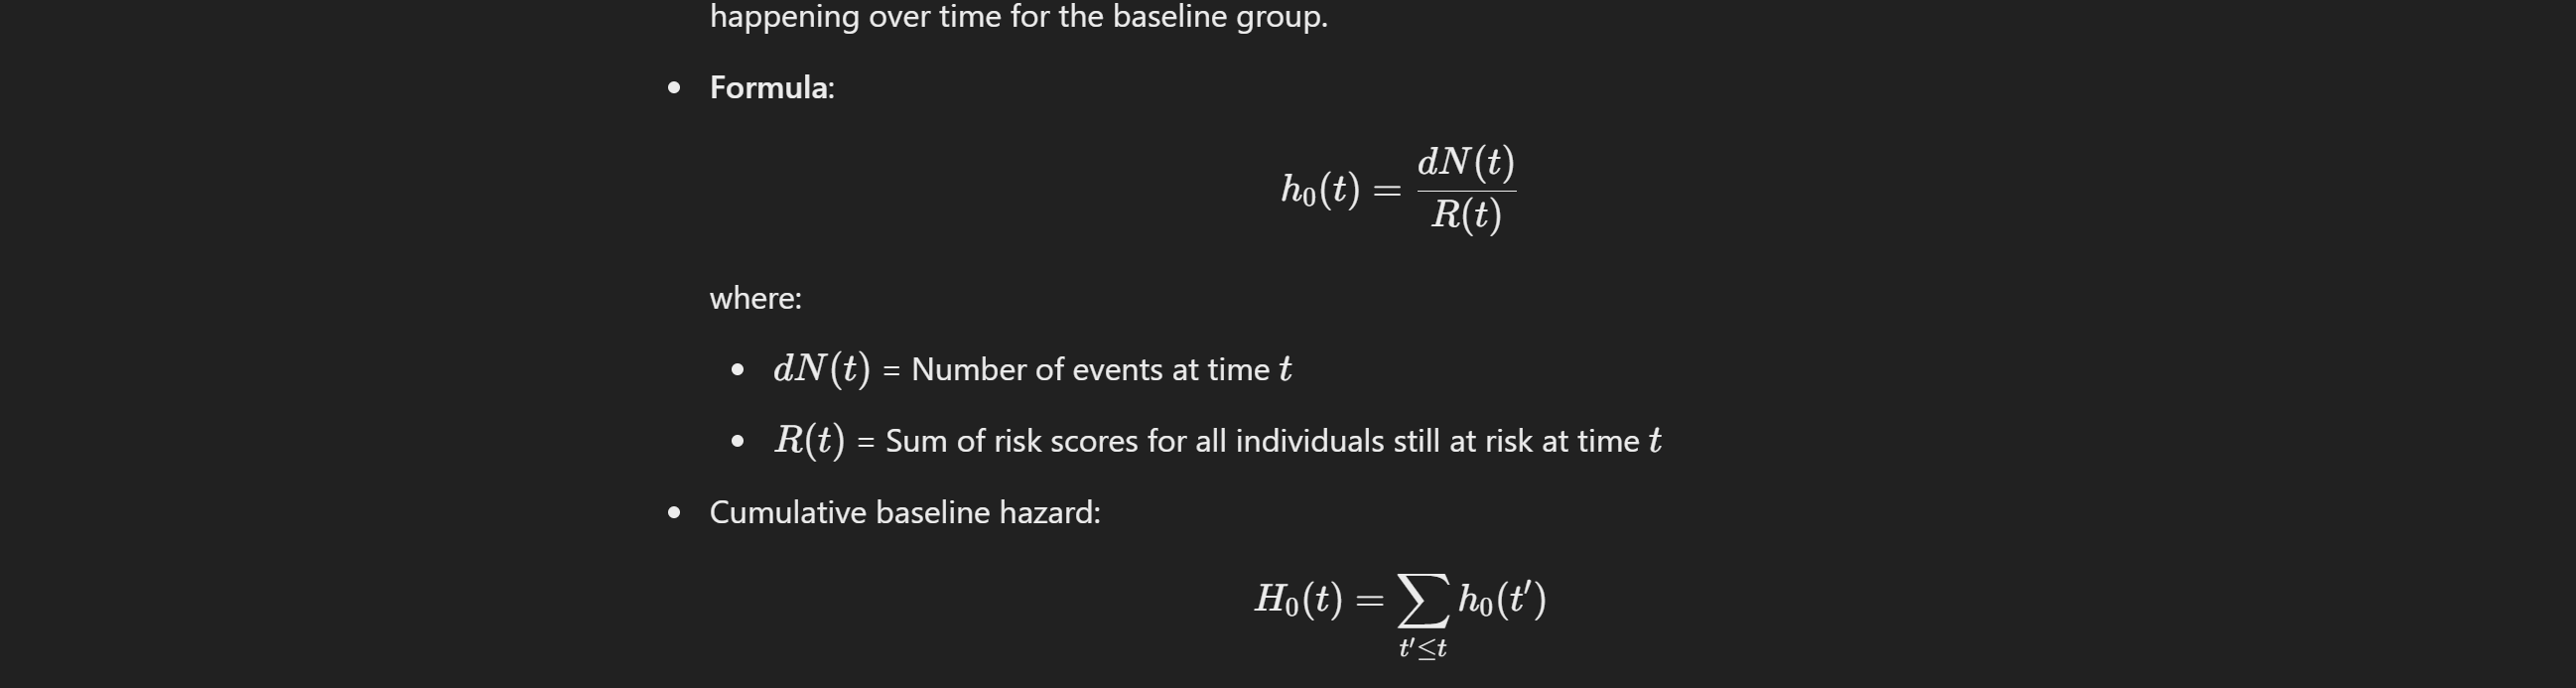


In [398]:
# Calculate Cumulative Baseline Hazard
unique_times, counts = np.unique(sorted_times, return_counts=True)  # Unique times and their counts of event for that time
cumulative_baseline_hazard = []
risk_sum = np.sum(sorted_risks)

for time, event_count in zip(unique_times, counts):
    hazard = event_count / risk_sum  # Events / At-risk in Formula dN(t)/R(t)
    if cumulative_baseline_hazard:
        cumulative_baseline_hazard.append(cumulative_baseline_hazard[-1] + hazard)  # Add to cumulative
    else:
        cumulative_baseline_hazard.append(hazard)  # First time point
    risk_sum -= np.sum(sorted_risks[sorted_times == time])  # Subtract patients who are no longer at risk

# Clip the cumulative baseline hazard to prevent extreme values
cumulative_baseline_hazard = np.clip(cumulative_baseline_hazard, 1e-6, None)


### Baseline Hazard Interpolation

In [399]:
# Estimate the cumulative baseline hazard for specific time points using interpolation.
# Interpolate baseline hazard for specified time points
baseline_hazards = np.interp(
    time_points,
    unique_times,
    cumulative_baseline_hazard,
    left=cumulative_baseline_hazard[0],
    right=cumulative_baseline_hazard[-1]
)


### Why Do We Interpolate?
Discreteness of Training Data:

The baseline hazard is calculated at specific survival times (e.g., [2, 5, 12, 25]) from the training data.
However, predictions might need survival probabilities at arbitrary time points (e.g., [1, 10, 20, 30]) not directly present in the training data.

Smoothness of the Survival Function:

Survival probabilities depend on the cumulative baseline hazard, which should be smoothly defined over time.
Interpolation ensures a continuous and meaningful estimate of the cumulative baseline hazard at any time, even between known survival times.
Flexibility in Time Predictions:

Interpolation allows the model to predict survival probabilities for any time point, regardless of whether that time point was observed in the training dataset.
For example, if the training data includes survival times [1, 5, 10] but you want to calculate survival at t=7, interpolation estimates the cumulative baseline hazard for t=7.
Consistency in Calculations:

Interpolation avoids gaps in the baseline hazard function by filling in values between observed time points. This ensures consistent behavior when computing survival probabilities.

## Calculate Survial Probability
[with Baseline Hazard and risk_factors (from the test data)]

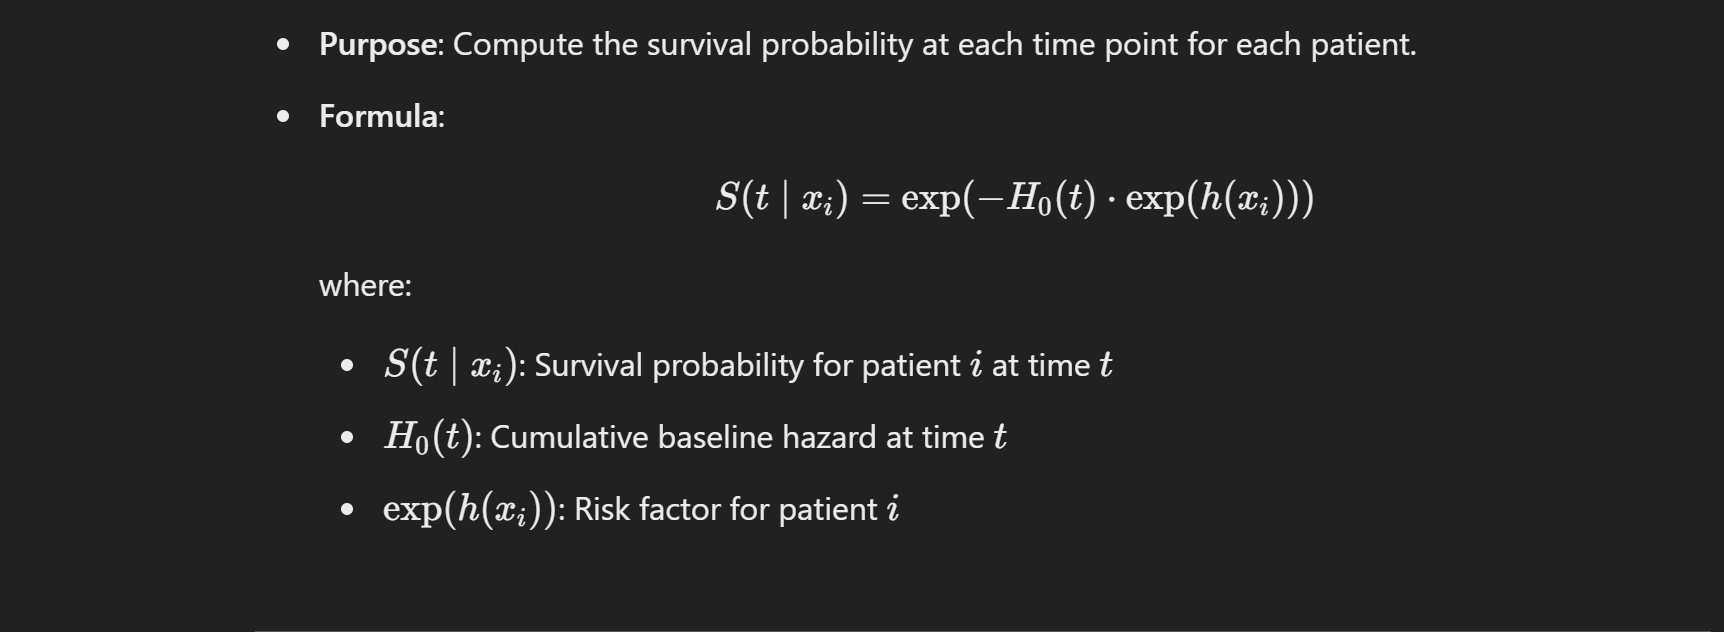

In [400]:
# Predict Risk Scores for Testing Data
risk_scores_test = deep_surv.predict(X_test_scaled).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [401]:
# Calculate survival probabilities
# Compute survival probabilities for all test patients
survival_probabilities = {}
for t, baseline_hazard in zip(time_points, baseline_hazards):
    # Correctly compute risk factors for each patient
    risk_factors = np.exp(risk_scores_test)
    risk_factors = np.clip(np.exp(risk_scores_test), 1e-3, 1e3)  # Adjust range to [1e-3, 1e3]
    survival_probabilities[t] = np.exp(-baseline_hazard * risk_factors)


#### **So what happened here ?**
We iterate through each pair of a specified time point (t) and its corresponding interpolated baseline hazard (baseline_hazard) and calculate the survival probability at each time point t. In other words, we apply the baseline hazards with the according time points t to all of the risk_scores.

### Extract the survival probability for t=60 and label the test data

In [402]:
# extract crucial survival time of 60 months
t60_probabilities_baseline = survival_probabilities[60]
# Predict labels based on threshold
optimal_threshold = 0.50  # Adjust threshold as necessary
# label test data
predicted_labels_t60_baseline = (t60_probabilities_baseline <= optimal_threshold).astype(int)

### Survival Model without baseline (actually irrelevant here lol)

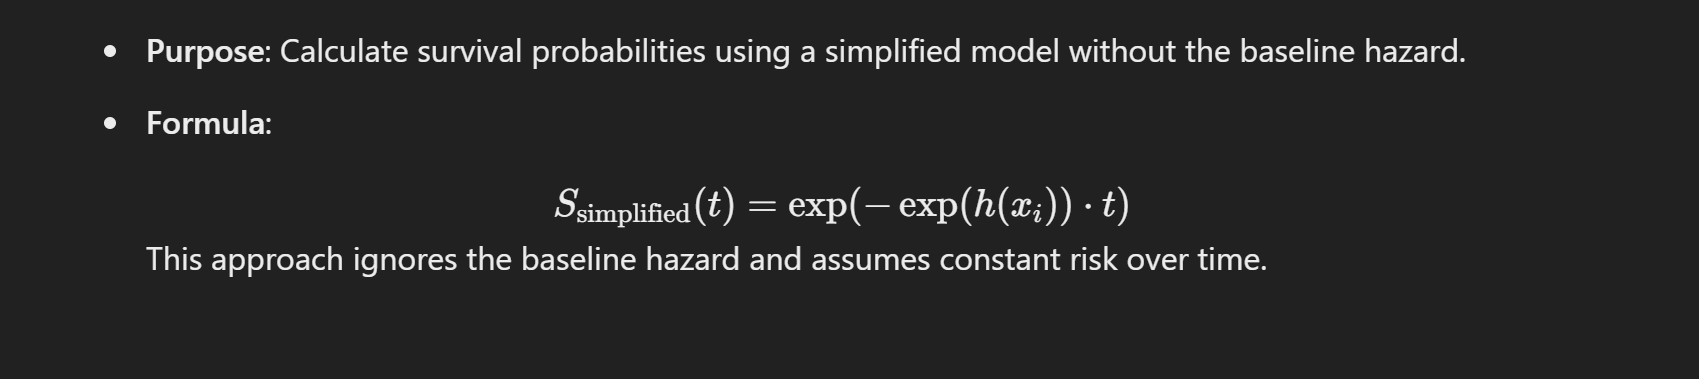

In [403]:
# This mimics a simpler model without a baseline hazard
time_point = 60  # Use t=60 for predictions
simplified_survival_probabilities = np.exp(-np.exp(risk_scores_test) * time_point)# * temporal_decay)
t60_probabilities_simplified = simplified_survival_probabilities
predicted_labels_t60_simplified = (t60_probabilities_simplified <= 0.00001).astype(int)


# Save predictions in a dataframe

In [404]:

# Save Predictions for All Time Points
# -------------------------------------
results = pd.DataFrame(survival_probabilities)
results['Predicted Label (Baseline, t=60)'] = predicted_labels_t60_baseline
results['Predicted Label (Simplified, t=60)'] = predicted_labels_t60_simplified
results['True Label'] = y_test
results_path = 'survival_predictions.csv'
results.to_csv(results_path, index=False)

# Evaluate model

In [405]:
# Evaluate Model for t=60
# ------------------------
accuracy_baseline = accuracy_score(y_test, predicted_labels_t60_baseline)
roc_auc_baseline = roc_auc_score(y_test, predicted_labels_t60_baseline)

accuracy_simplified = accuracy_score(y_test, predicted_labels_t60_simplified)
roc_auc_simplified = roc_auc_score(y_test, predicted_labels_t60_simplified)

print(f"Baseline Model - Accuracy (t=60): {accuracy_baseline:.2f}, ROC AUC: {roc_auc_baseline:.2f}")
print(f"Simplified Model - Accuracy (t=60): {accuracy_simplified:.2f}, ROC AUC: {roc_auc_simplified:.2f}")



Baseline Model - Accuracy (t=60): 0.82, ROC AUC: 0.83
Simplified Model - Accuracy (t=60): 0.85, ROC AUC: 0.85


In [406]:
baseline_data.columns

Index(['ESR1', 'PGR', 'ERBB2', 'MKI67', 'PLAU', 'ELAVL1', 'EGFR', 'BTRC',
       'FBXO6', 'SHMT2', 'KRAS', 'SRPK2', 'YWHAQ', 'PDHA1', 'EWSR1', 'ZDHHC17',
       'ENO1', 'DBN1', 'PLK1', 'GSK3B', 'Age', 'Menopausal State', 'Size',
       'Radio Therapy', 'Chemotherapy', 'Hormone Therapy',
       'Neoplasm Histologic Grade', 'Cellularity', 'Surgery-breast conserving',
       'Surgery-mastectomy', 'Label', 'DssTime', 'Event'],
      dtype='object')

### Create a Survival Plot for a patient

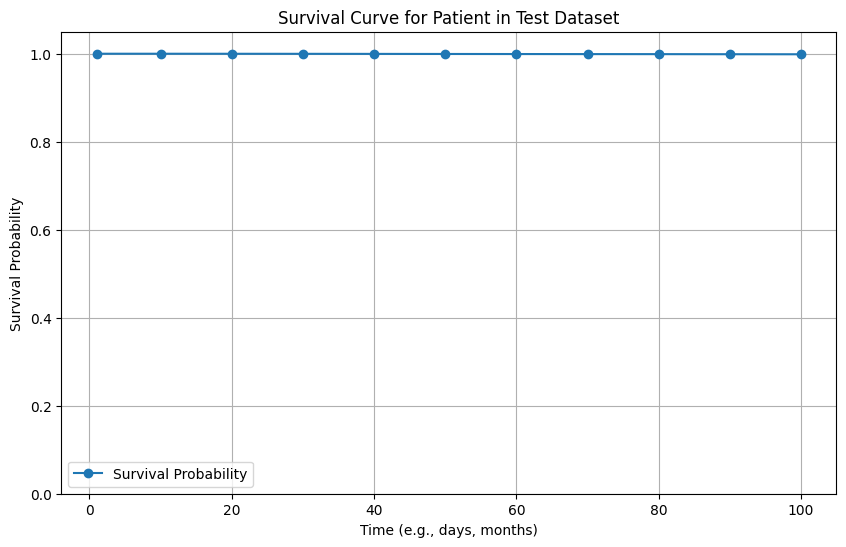


months:  1
survival probability:  0.99999744

months:  10
survival probability:  0.99997485

months:  20
survival probability:  0.99989593

months:  30
survival probability:  0.99978346

months:  40
survival probability:  0.9996285

months:  50
survival probability:  0.99944776

months:  60
survival probability:  0.99930686

months:  70
survival probability:  0.99916524

months:  80
survival probability:  0.9990703

months:  90
survival probability:  0.99887735

months:  100
survival probability:  0.9987577


In [407]:
# Extract survival probabilities for the 5th patient
import matplotlib.pyplot as plt
first_patient_probabilities = [survival_probabilities[t][1] for t in time_points]

# Plot the survival curve for the first patient
plt.figure(figsize=(10, 6))
plt.plot(time_points, first_patient_probabilities, marker='o', label="Survival Probability")
plt.title("Survival Curve for Patient in Test Dataset")
plt.xlabel("Time (e.g., days, months)")
plt.ylabel("Survival Probability")
plt.ylim(0, 1.05)  # Ensure the y-axis is between 0 and 1
plt.grid(True)
plt.legend()
plt.show()

# patients survival scores
for i in time_points:
  print("")
  print("months: ",i)
  print("survival probability: ",survival_probabilities[i][1])

In [408]:
t60_probabilities_baseline

array([1.2356403e-01, 9.9930686e-01, 1.8803743e-01, 5.8882833e-01,
       7.5986338e-01, 1.6916819e-01, 9.9930686e-01, 9.9930686e-01,
       2.6583695e-01, 7.5790113e-01, 6.5639591e-01, 9.9930686e-01,
       8.6281544e-01, 9.5032161e-01, 3.1477335e-01, 4.9295485e-02,
       4.6731383e-01, 1.9602519e-01, 9.8203784e-01, 8.5794353e-01,
       2.3567830e-08, 9.8047370e-01, 9.9148607e-01, 9.2375473e-07,
       9.9930686e-01, 3.5270143e-03, 9.9924660e-01, 1.8273771e-01,
       9.9295729e-01, 1.6849093e-02, 9.9930686e-01, 9.5680404e-01,
       9.9930686e-01, 7.2786862e-01, 9.9930686e-01, 9.9930686e-01,
       1.6308394e-01, 8.4886473e-01, 9.9930686e-01, 9.9541467e-01,
       8.1333530e-01, 2.9916969e-01, 9.9930686e-01, 8.6569953e-01,
       9.6896970e-01, 8.3532071e-01, 2.2498455e-03, 4.1952708e-01,
       3.0377114e-01, 9.9112612e-01, 9.8992449e-01, 9.9930686e-01,
       4.6451119e-01, 9.9930686e-01, 2.1503025e-01, 9.5688921e-01,
       9.9930686e-01, 9.9930686e-01, 9.7394830e-01, 9.9930686e

# Explainability


In [409]:
sorted_indices

,DssTime
0,403
1,426
2,37
3,126
4,57
...,...
460,169
461,383
462,211
463,184
